# Insights from Kaggle Survey 2018

## 1. Data Exploration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import folium
import branca
from babel.numbers import *
from textwrap import wrap
from folium.plugins import Search
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


kaggle = pd.read_csv('multipleChoiceResponses.csv',low_memory=False)

gdf = gpd.read_file('ne_110m_admin_0_countries.shp')[['ADMIN', 'ADM0_A3', 'geometry']]

gdf.columns = ['country', 'country_code', 'geometry']

In [2]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

## 2. Data Preprocessing

In [3]:
def convert_country(x):
    if x == 'Czech Republic':
        return 'Czechia'
    elif x == 'Viet Nam':
        return 'Vietnam'
    elif x == 'Republic of Korea':
        return 'South Korea'
    elif x == 'Hong Kong (S.A.R.)':
        return 'China'
    elif x == 'Iran, Islamic Republic of...':
        return 'Iran'
    elif x == 'United Kingdom of Great Britain and Northern Ireland':
        return 'United Kingdom'
    else:
        return x

In [4]:
def median_salary(x):
    if x == 'I do not wish to disclose my approximate yearly compensation' or type(x) == float:
        return np.nan
    elif x == '500,000+':
        return parse_number(x[:7],locale='en_US')
    else:
        return (parse_number(x.split('-')[0],locale='en_US')*1000+parse_number(x.split('-')[1],locale='en_US'))/2

In [5]:
def data_preprocessing(kaggle_data):
    kaggle_no_title = kaggle.iloc[1:,:].copy()
    kaggle_no_title.loc[:,'Q3'] = kaggle_no_title.loc[:,'Q3'].apply(convert_country)
    kaggle_no_title.loc[:,'median_salary'] = kaggle_no_title.loc[:,'Q9'].apply(median_salary)
    
    return kaggle_no_title

In [6]:
kaggle_no_title = data_preprocessing(kaggle)

## 3. Data Visualization

### Q1. What's the background of respondents ?

#### 1.1 Distribution map of respondents

In [7]:
country_count = kaggle_no_title.loc[:,'Q3'].value_counts().rename_axis('country').reset_index(name='count')
country_coor = gdf.merge(country_count,on = 'country',how = 'left').fillna(0)
final_country = country_coor[['country','geometry','count']]


colormap = branca.colormap.LinearColormap(
    colors=['#fcfbfd','#bcbddc','#807dba','#6a51a3','#3f007d'],
    index=final_country['count'].quantile([0.65,0.94,0.98,0.99,1.0]),
    vmin=0,
    vmax=max(final_country['count']),
    caption="Number of respondent"
)


m = folium.Map(location=[23, 5],height='90%',zoom_start = 2)

colormap.add_to(m)

style_function = lambda x: {
    'fillColor': colormap(x['properties']['count']),
    'color': 'black',
    'weight':1,
    'fillOpacity':0.5
}

highlight_function = lambda x: {
    'fillColor': colormap(x['properties']['count']),
    'color': 'red',
    'weight':1,
    'fillOpacity':0.5
}

countrygeo = folium.GeoJson(
    final_country,
    name='country_count',
    style_function=style_function,
    highlight_function = highlight_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['country', 'count'],
        aliases=['Country', 'Count'], 
        localize=True
    )
).add_to(m)

countrysearch = Search(
    layer=countrygeo,
    geom_type='Polygon',
    placeholder='Search for a country',
    collapsed=False,
    search_label='country',
    weight=3
).add_to(m)

folium.LayerControl().add_to(m)

m

#### 1.2 Percentage of respondents by gender and age

In [8]:
sns.set()

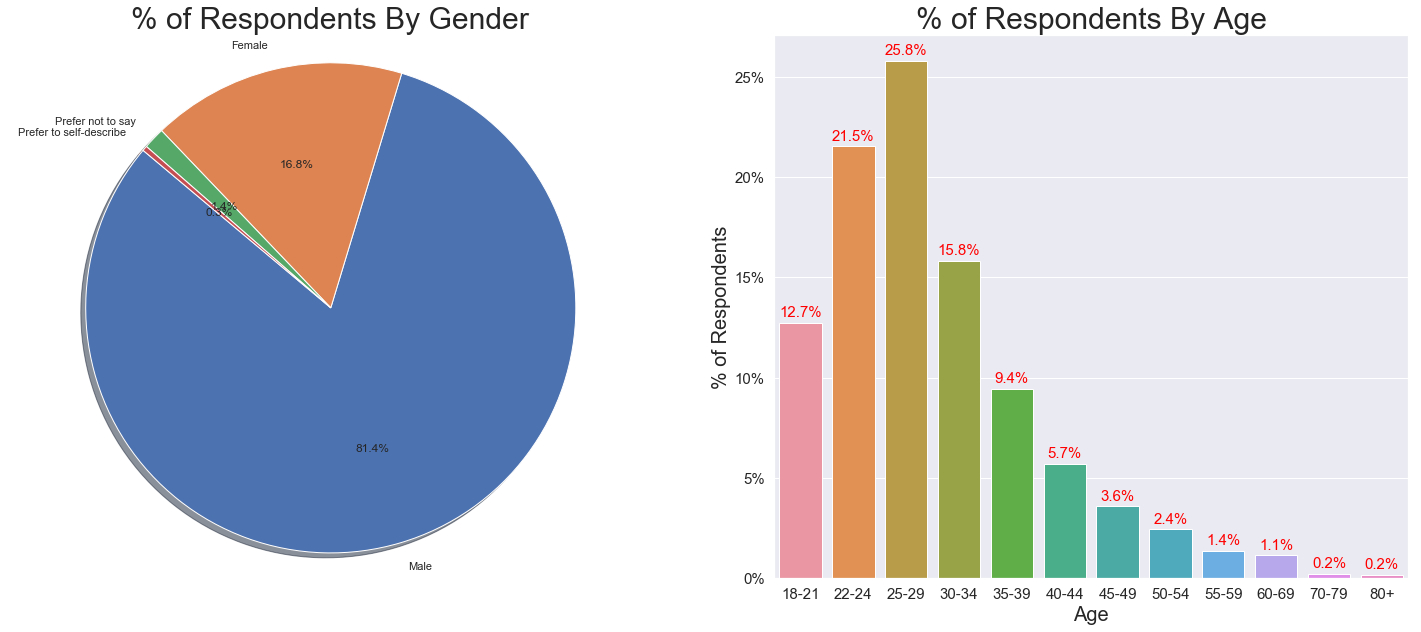

In [9]:
plt.figure(figsize=(25,10))

ax1 = plt.subplot2grid((1,2),(0,0))
gender = kaggle_no_title['Q1'].value_counts(normalize=True)
labels = np.asarray(list(gender.index))
sizes = gender.values

plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
ax1.set_title('% of Respondents By Gender',fontsize=30)
plt.axis('equal')

ax2 = plt.subplot2grid((1,2),(0,1))
age = kaggle_no_title['Q2'].value_counts(normalize=True).reindex(['18-21','22-24','25-29','30-34','35-39','40-44',
                                                                  '45-49','50-54','55-59','60-69','70-79','80+'])

ax = sns.barplot(x=np.asarray(list(age.index)),y=age.values)

ax.tick_params(labelsize=15)
ax.set_xlabel('Age', fontsize = 20)
ax.set_ylabel('% of Respondents', fontsize = 20)
ax.set_title('% of Respondents By Age',fontsize=30)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p:"{0:.0%}".format(x)))
    
for p in plt.gca().patches:
            ax.text(p.get_x()+p.get_width()-0.4, p.get_height()+0.005, "{0:.1%}".format(p.get_height()), 
                    fontsize=15, color='red', ha='center',va='center')


#### 1.3 Percentage of respondents by experience

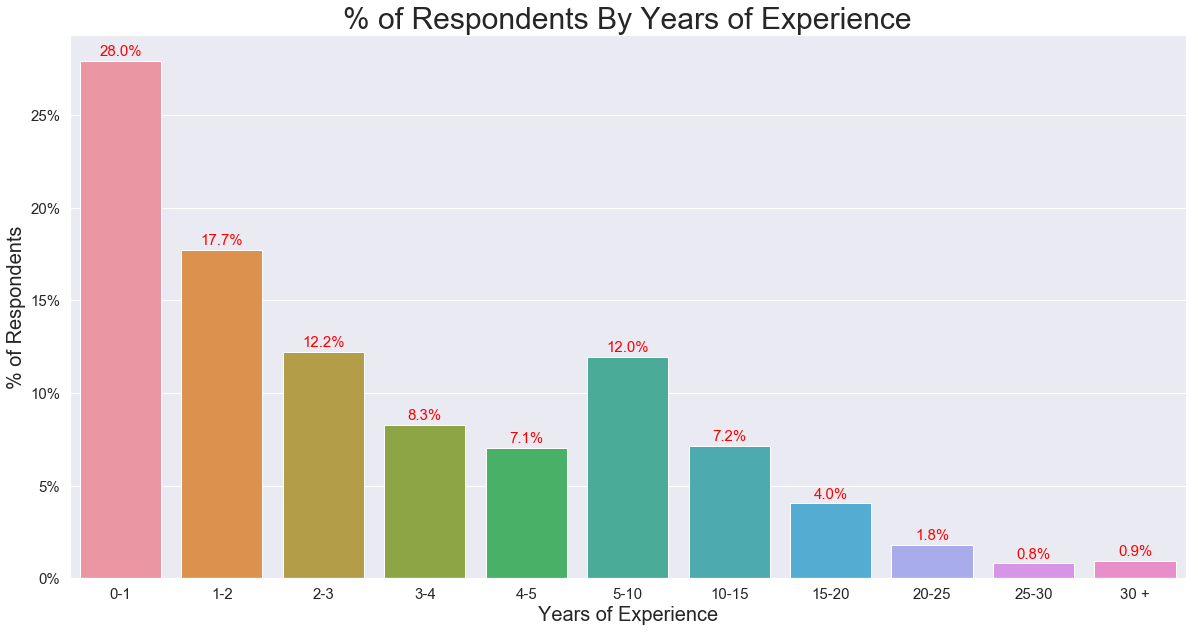

In [10]:
plt.figure(figsize=(20,10))

exp = kaggle_no_title['Q8'].value_counts(normalize=True).reindex(['0-1','1-2','2-3','3-4','4-5','5-10',
                                                                    '10-15','15-20','20-25','25-30','30 +'])

ax = sns.barplot(x=np.asarray(list(exp.index)),y=exp.values)

ax.tick_params(labelsize=15)
ax.set_xlabel('Years of Experience', fontsize = 20)
ax.set_ylabel('% of Respondents', fontsize = 20)
ax.set_title('% of Respondents By Years of Experience',fontsize=30)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p:"{0:.0%}".format(x)))
    
for p in plt.gca().patches:
            ax.text(p.get_x()+p.get_width()-0.4, p.get_height()+0.005, "{0:.1%}".format(p.get_height()), 
                    fontsize=15, color='red', ha='center',va='center')

plt.show()

### Q2. What are some of the interesting facts about Data Science/Machine Learning

#### 2.1 Percentage of industry apply machine learning

In [11]:
def group_ml(x):
    if x == 'I do not know' or x == 'No (we do not use ML methods)':
        return 'Not Involved'
    else:
        return 'Involved'

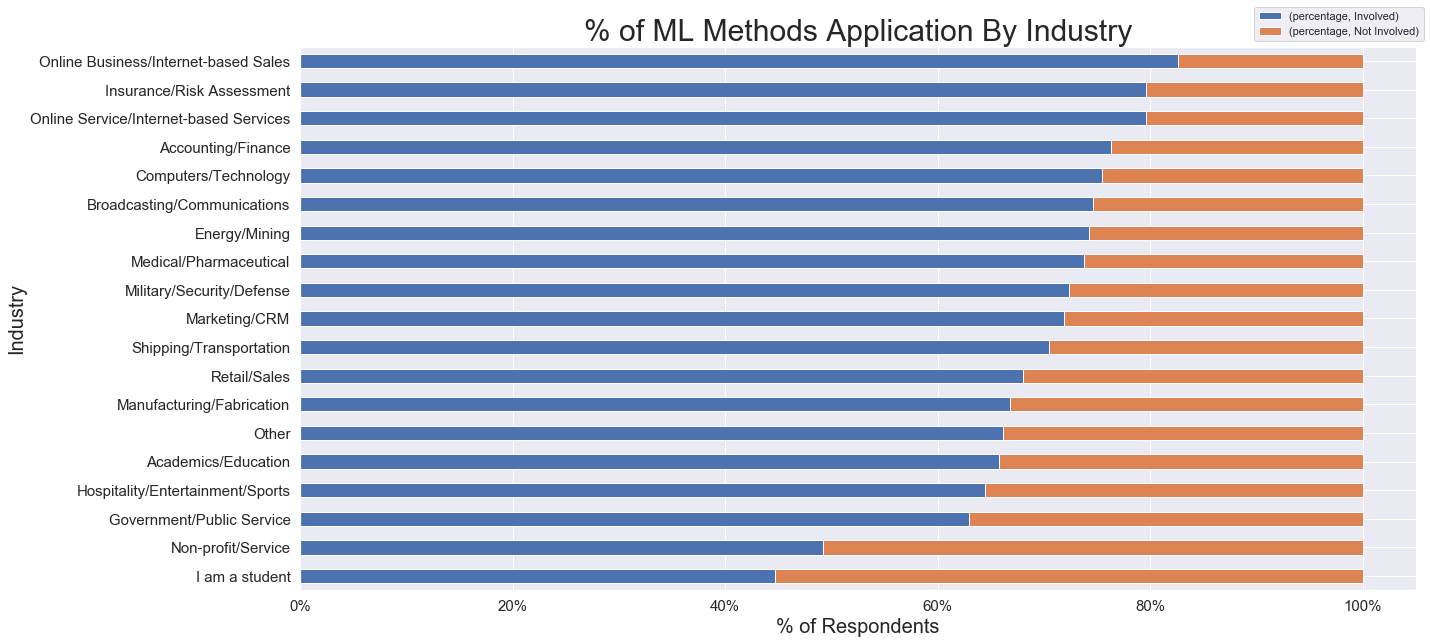

In [12]:
kaggle_no_title['ML_Methods'] = kaggle_no_title['Q10'].apply(group_ml)

ml_in_industry = kaggle_no_title.groupby(['Q7','ML_Methods']).size().rename('count').reset_index()
ml_in_industry['percentage'] = ml_in_industry.groupby(['Q7'])['count'].apply(lambda x:x / float(x.sum()))
ml_in_industry = ml_in_industry.drop(columns=['count']).pivot(columns='ML_Methods', index='Q7')\
                                                       .sort_values(('percentage','Involved'))

ax = ml_in_industry.plot(kind='barh', stacked=True,figsize=(20,10),legend=False)
ax.tick_params(labelsize=15)
ax.set_xlabel('% of Respondents', fontsize = 20)
ax.set_ylabel('Industry', fontsize = 20)
ax.set_title('% of ML Methods Application By Industry',fontsize=30)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p:"{0:.0%}".format(x)))
ax.legend(bbox_to_anchor=(0.85,1))

#### 2.2 Median salary by job title

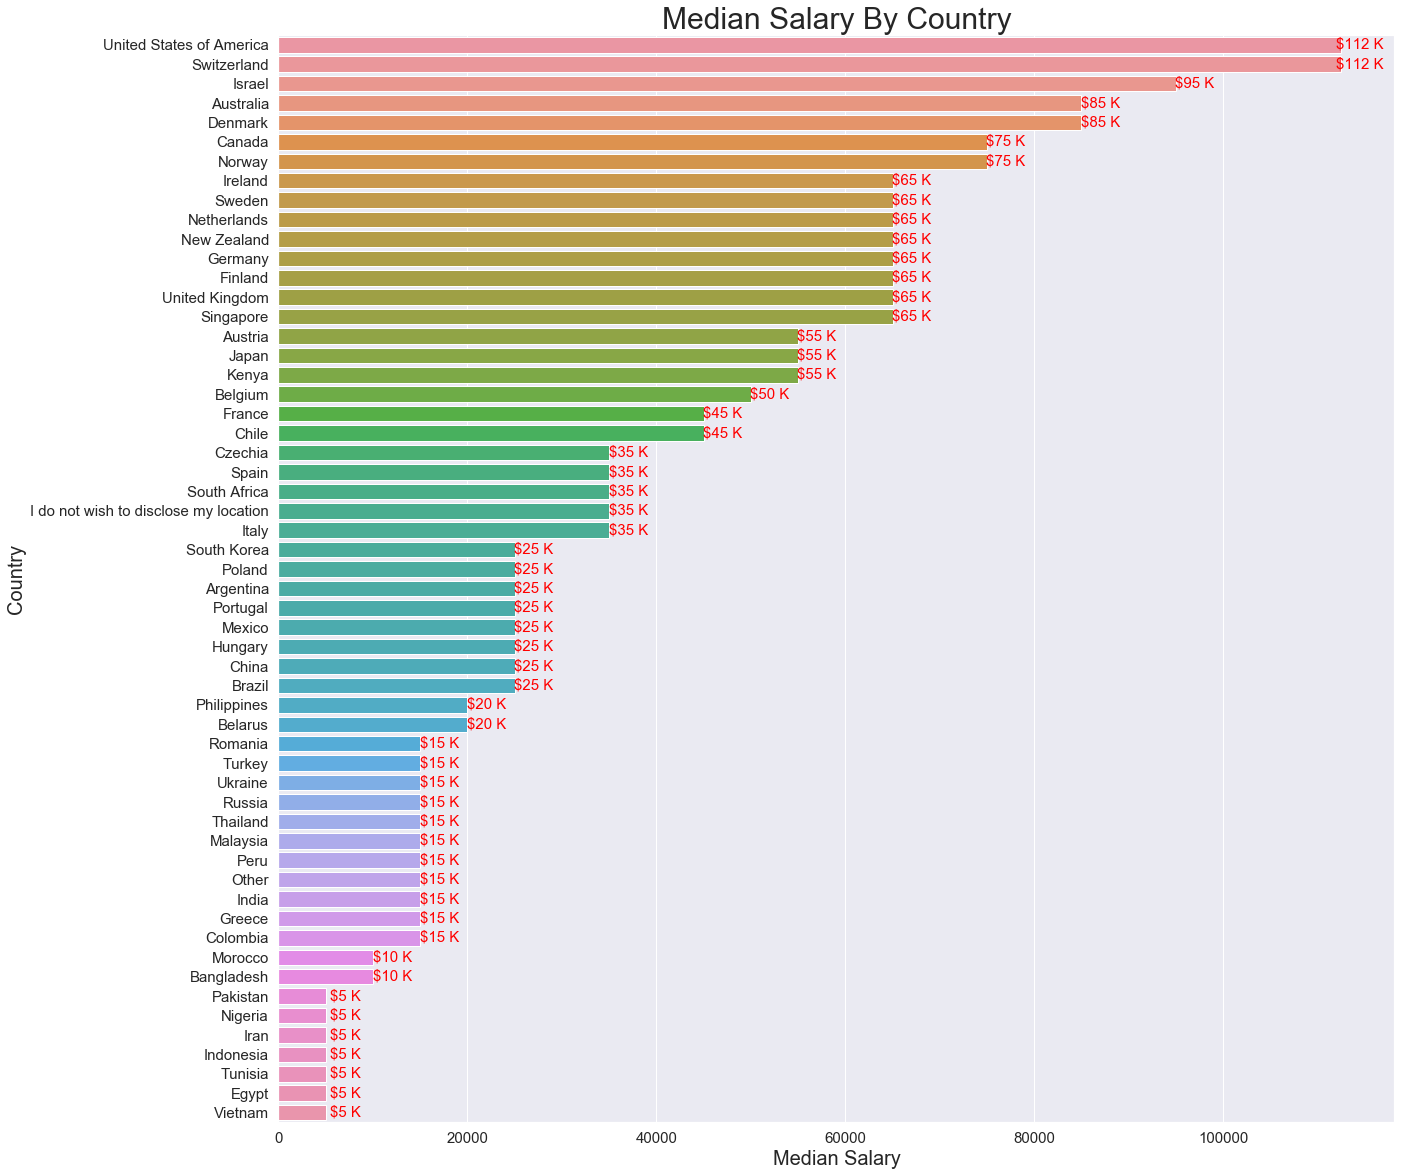

In [13]:
plt.figure(figsize=(20,20))

ds_de = kaggle_no_title[(kaggle_no_title['Q6'] == 'Data Scientist')|(kaggle_no_title['Q6'] == 'Data Engineer')]
salary_by_pos = pd.DataFrame(ds_de[['Q3','median_salary']].groupby(['Q3'],as_index=False)['median_salary'].median()\
                            .sort_values(by='median_salary',ascending = False)).reset_index(drop=True).dropna()

ax = sns.barplot(x=salary_by_pos['median_salary'],y=np.asarray(list(salary_by_pos['Q3'])))

ax.tick_params(labelsize=15)
ax.set_xlabel('Median Salary', fontsize = 20)
ax.set_ylabel('Country', fontsize = 20)
ax.set_title('Median Salary By Country',fontsize=30)

for p in plt.gca().patches:
            ax.text(p.get_y()+p.get_width()+2000, p.get_y() + p.get_height()/2, 
                    format_currency(p.get_width(), 'USD', locale='en_US').split(',')[0]+' K',
                    fontsize=15, color='red', ha='center',va='center')

plt.show()

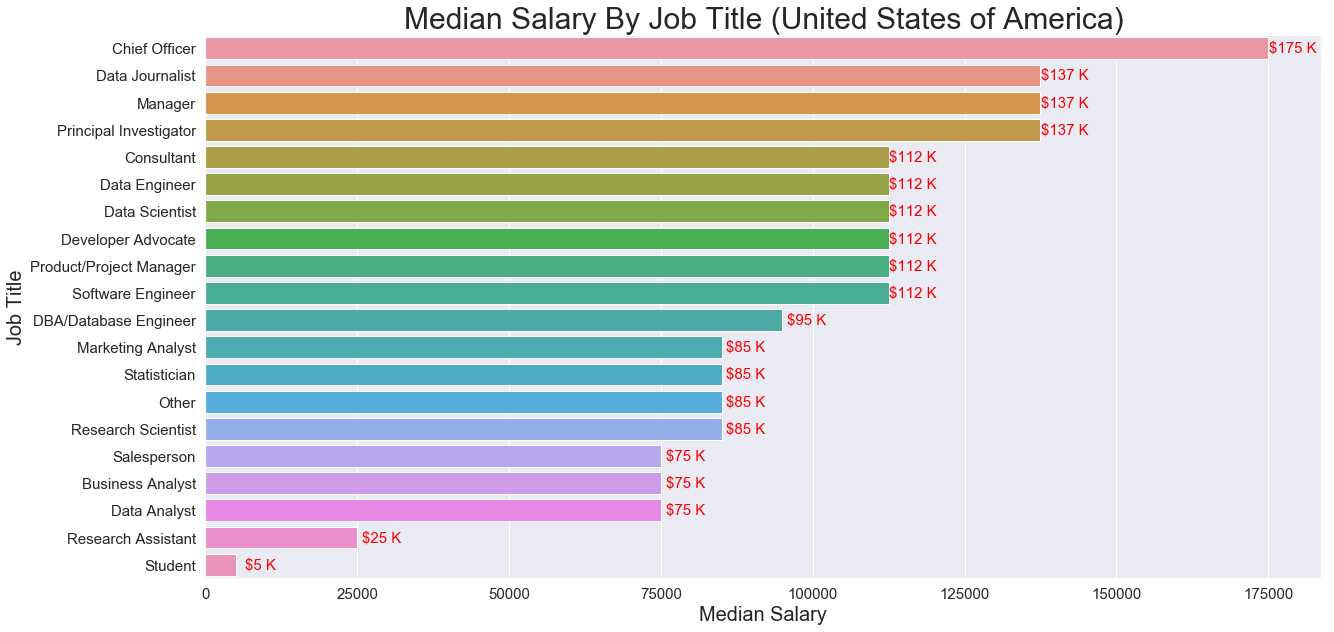

In [14]:
plt.figure(figsize=(20,10))

salary_by_pos = pd.DataFrame(kaggle_no_title[kaggle_no_title['Q3']=='United States of America']\
                             [['Q6','median_salary']].groupby(['Q6'],as_index=False)['median_salary'].median()\
                            .sort_values(by='median_salary',ascending = False)).reset_index(drop=True).dropna()

ax = sns.barplot(x=salary_by_pos['median_salary'],y=np.asarray(list(salary_by_pos['Q6'])))

ax.tick_params(labelsize=15)
ax.set_xlabel('Median Salary', fontsize = 20)
ax.set_ylabel('Job Title', fontsize = 20)
ax.set_title('Median Salary By Job Title (United States of America)',fontsize=30)

for p in plt.gca().patches:
            ax.text(p.get_y()+p.get_width()+4000, p.get_y() + p.get_height()/2, 
                    format_currency(p.get_width(), 'USD', locale='en_US').split(',')[0]+' K',
                    fontsize=15, color='red', ha='center',va='center')

plt.show()

### Q3. How to get into the field of Data Science ?

#### 3.1 Percentage of respondents by education level

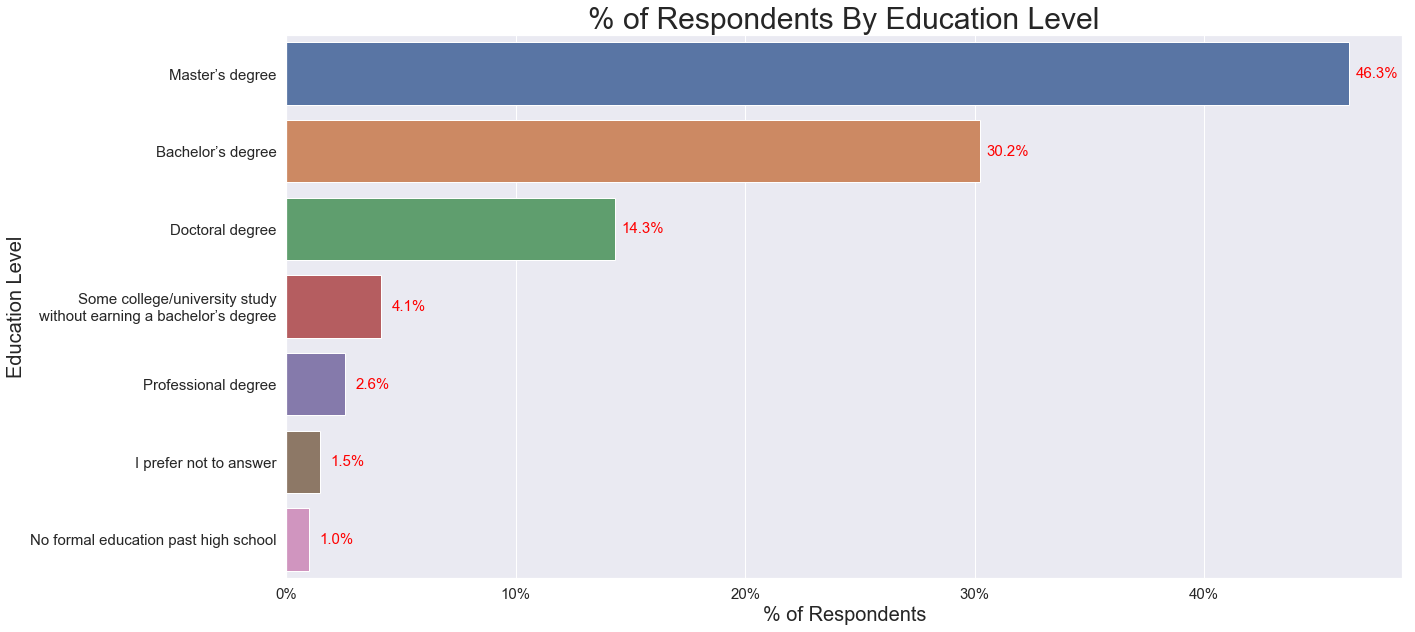

In [21]:
plt.figure(figsize=(20,10))

edu = kaggle_no_title['Q4'].value_counts(normalize=True)

ax = sns.barplot(x=edu.values,y=np.asarray(list(edu.index)))

ax.tick_params(labelsize=15)
ax.set_xlabel('% of Respondents', fontsize = 20)
ax.set_ylabel('Education Level', fontsize = 20)
ax.set_title('% of Respondents By Education Level',fontsize=30)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p:"{0:.0%}".format(x)))

wrap_labels = ['\n'.join(wrap(l, 36)) for l in list(edu.index)]
ax.set_yticklabels(wrap_labels)


for p in plt.gca().patches:
            ax.text(p.get_width()+0.012, p.get_y() + p.get_height()/2, "{0:.1%}".format(p.get_width()), 
                    fontsize=15, color='red', ha='center',va='center')

plt.show()

#### 3.2 Percentage of repsondents by major

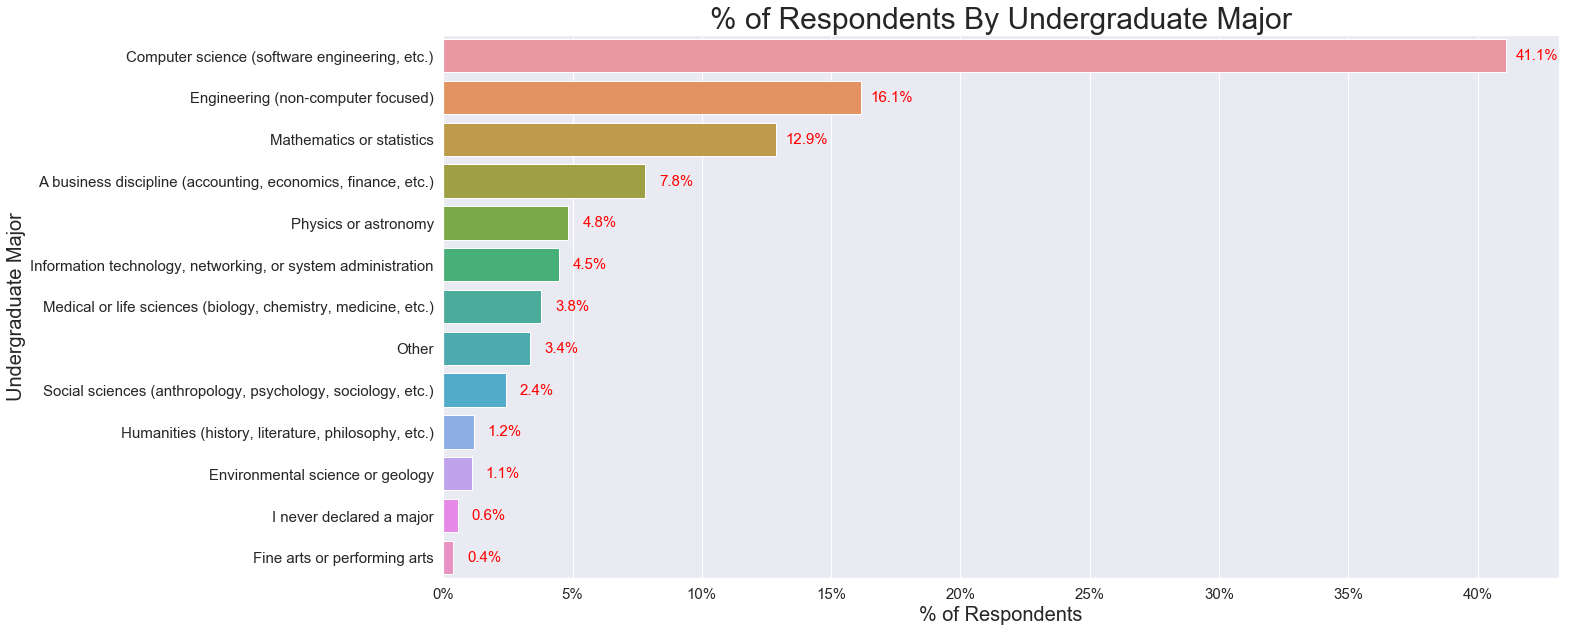

In [16]:
plt.figure(figsize=(20,10))

maj = kaggle_no_title['Q5'].value_counts(normalize=True)

ax = sns.barplot(x=maj.values,y=np.asarray(list(maj.index)))

ax.tick_params(labelsize=15)
ax.set_xlabel('% of Respondents', fontsize = 20)
ax.set_ylabel('Undergraduate Major', fontsize = 20)
ax.set_title('% of Respondents By Undergraduate Major',fontsize=30)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p:"{0:.0%}".format(x)))

for p in plt.gca().patches:
            ax.text(p.get_width()+0.012, p.get_y() + p.get_height()/2, "{0:.1%}".format(p.get_width()), 
                    fontsize=15, color='red', ha='center',va='center')

plt.show()

#### 3.3 Percentage of respondents by programming languages

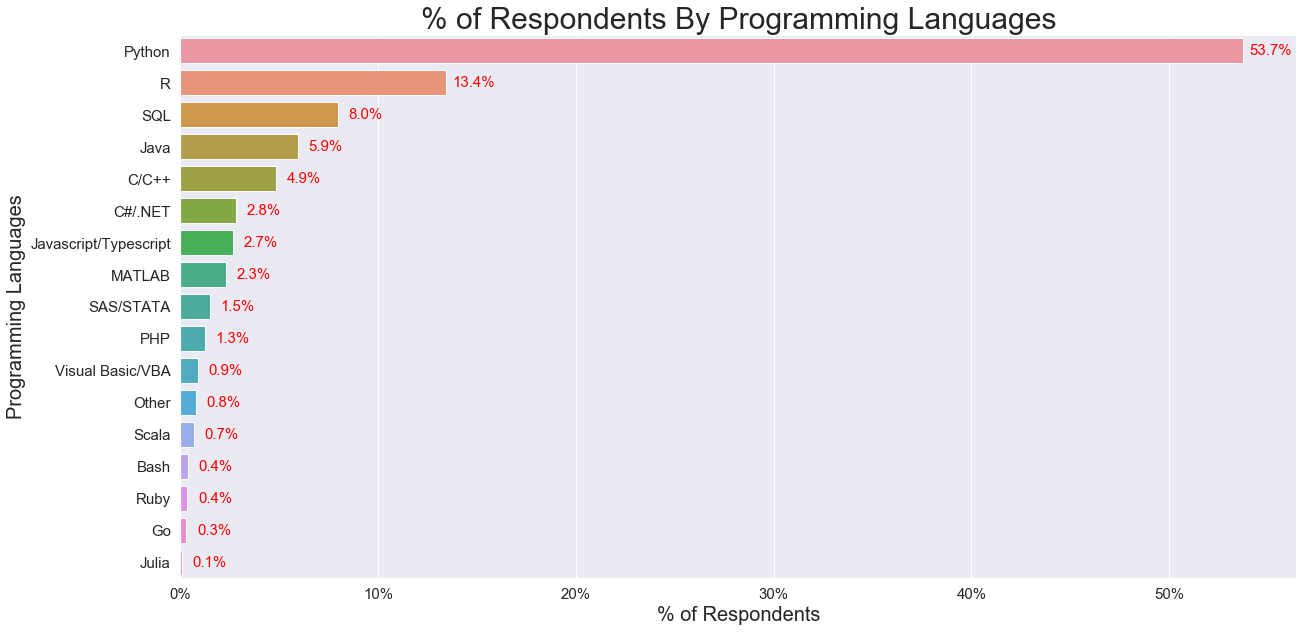

In [17]:
plt.figure(figsize=(20,10))

lang = kaggle.iloc[1:,:]['Q17'].value_counts(normalize=True)

ax = sns.barplot(x=lang.values,y=np.asarray(list(lang.index)))

ax.tick_params(labelsize=15)
ax.set_xlabel('% of Respondents', fontsize = 20)
ax.set_ylabel('Programming Languages', fontsize = 20)
ax.set_title('% of Respondents By Programming Languages',fontsize=30)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p:"{0:.0%}".format(x)))
    
for p in plt.gca().patches:
            ax.text(p.get_width()+0.014, p.get_y() + p.get_height()/2, "{0:.1%}".format(p.get_width()), 
                    fontsize=15, color='red', ha='center',va='center')

plt.show()

#### 3.4 Percentage of respondents by online courses participation

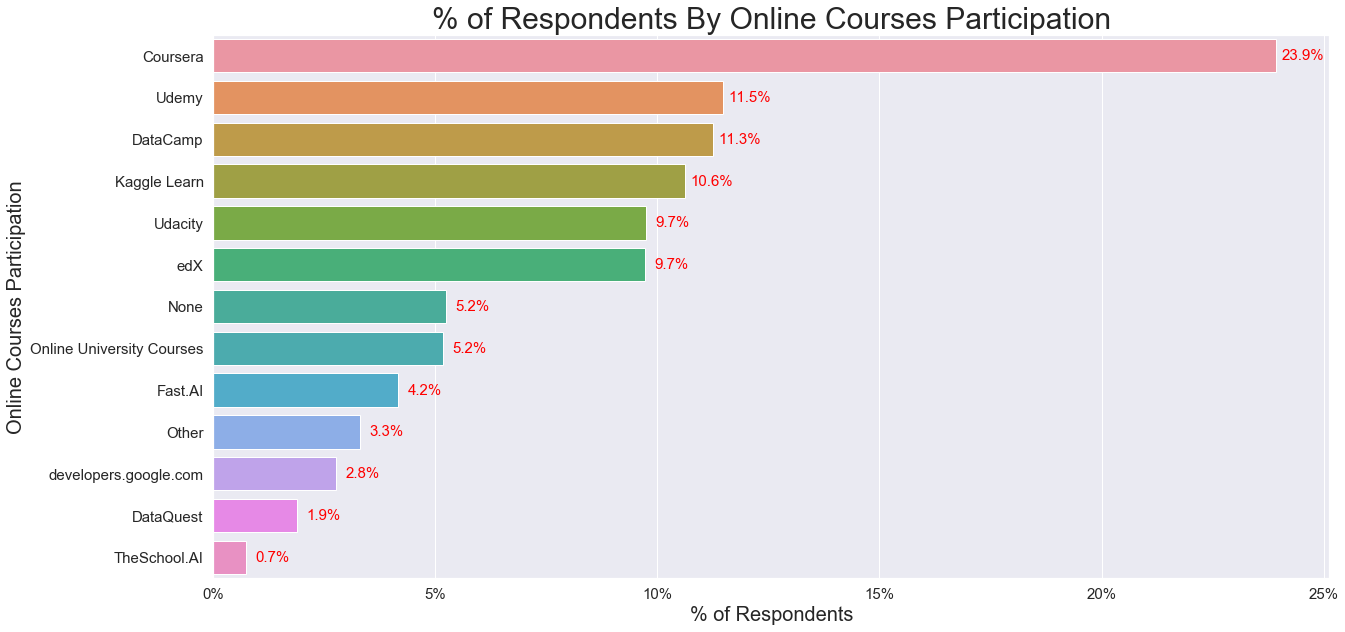

In [18]:
plt.figure(figsize=(20,10))

total_response = np.sum(kaggle[['Q36_Part_1','Q36_Part_2','Q36_Part_3','Q36_Part_4','Q36_Part_5','Q36_Part_6',
                              'Q36_Part_7','Q36_Part_8','Q36_Part_9','Q36_Part_10','Q36_Part_11','Q36_Part_12',
                              'Q36_Part_13']].notnull().sum().values)

course = (kaggle[['Q36_Part_1','Q36_Part_2','Q36_Part_3','Q36_Part_4','Q36_Part_5','Q36_Part_6',
                              'Q36_Part_7','Q36_Part_8','Q36_Part_9','Q36_Part_10','Q36_Part_11','Q36_Part_12',
                              'Q36_Part_13']].notnull().sum()/total_response).sort_values(ascending=False)

course = course.rename({'Q36_Part_1':'Udacity','Q36_Part_2':'Coursera','Q36_Part_3':'edX','Q36_Part_4':'DataCamp',
                        'Q36_Part_5':'DataQuest','Q36_Part_6':'Kaggle Learn','Q36_Part_7':'Fast.AI',
                        'Q36_Part_8':'developers.google.com','Q36_Part_9':'Udemy','Q36_Part_10':'TheSchool.AI',
                        'Q36_Part_11':'Online University Courses','Q36_Part_12':'None','Q36_Part_13':'Other'})

ax = sns.barplot(x=course.values,y=np.asarray(list(course.index)))

ax.tick_params(labelsize=15)
ax.set_xlabel('% of Respondents', fontsize = 20)
ax.set_ylabel('Online Courses Participation', fontsize = 20)
ax.set_title('% of Respondents By Online Courses Participation',fontsize=30)
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p:"{0:.0%}".format(x)))

for p in plt.gca().patches:
            ax.text(p.get_width()+0.006, p.get_y() + p.get_height()/2, "{0:.1%}".format(p.get_width()), 
                    fontsize=15, color='red', ha='center',va='center')

plt.show()